<a href="https://colab.research.google.com/github/KartikayBhardwaj-dev/Deep_learning_college/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Understanding Transformers**

**Course:** Deep Learning and Generative AI  
**Institution:** IIT Madras  
**Author:** Prof. Balaji Srinivasan  
**Date:** November 2025  

---

## **Learning Objectives**

By the end of this tutorial, students will be able to:

1. **Understand** the fundamental architecture and components of transformer models
2. **Implement** attention mechanisms including self-attention and multi-head attention
3. **Visualize** embeddings, attention weights, and transformer layer outputs
4. **Build** a complete GPT-style language model from scratch using PyTorch
5. **Train** transformer models for next-token prediction tasks
6. **Analyze** how attention patterns emerge and contribute to model performance
7. **Generate** text using trained transformer models with temperature and top-k sampling

---

## **Prerequisites**

- Strong understanding of PyTorch fundamentals (tensors, autograd, neural networks)
- Familiarity with recurrent neural networks (RNNs) and their limitations
- Knowledge of embeddings and positional encodings
- Understanding of sequence-to-sequence models and language modeling
- Basic linear algebra concepts (matrix multiplication, dot products)
- Experience with natural language processing concepts

---

**Source**: The contents are borrowed from the blog by Robert Timm (https://rti.github.io/gptvis/)

## **1. Overview and Theoretical Framework**

### **1.1 Introduction to Transformer Architecture**

The transformer architecture, introduced in the seminal paper "Attention is All You Need" (Vaswani et al., 2017), revolutionized deep learning by replacing recurrent and convolutional layers with **self-attention mechanisms**. This paradigm shift enabled:

- **Parallel processing** of sequences, dramatically reducing training time
- **Long-range dependencies** captured more effectively than RNNs
- **Scalability** to massive datasets and model sizes

### **1.2 Pedagogical Approach**

This tutorial builds a complete GPT-style language model from the ground up, demonstrating each component of the transformer architecture through hands-on implementation. We emphasize **visualization techniques** to develop intuition about how transformers process information, using 3D representations of embeddings and attention patterns.

### **1.3 Key Components Covered**

| **Component** | **Purpose** | **Implementation Details** |
|---------------|-------------|---------------------------|
| **Token Embeddings** | Convert discrete tokens to continuous vectors | Learned embedding table mapping vocabulary to n-dimensional space |
| **Positional Embeddings** | Encode sequence order information | Learned positional encodings added to token embeddings |
| **Self-Attention** | Allow tokens to attend to other tokens | Query-Key-Value mechanism with masking for autoregressive generation |
| **Multi-Head Attention** | Parallel attention computations | Multiple attention heads learning different aspects of relationships |
| **Feed-Forward Networks** | Non-linear transformations | Position-wise fully connected layers with residual connections |
| **Layer Normalization** | Stabilize training | Normalize activations across embedding dimension |
| **Residual Connections** | Enable deep networks | Skip connections preventing gradient degradation |

## **2. Environment Setup and Dependencies**

In [ ]:
!pip install -q pyglet pyvirtualdisplay
!pip install -q pyvista
!apt-get -qq install xvfb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.5 MB/s eta 0:00:00


In [ ]:
# Import essential libraries for transformer implementation and visualization
from pyvirtualdisplay.display import Display
import pyvista as pv          # 3D visualization of embeddings and attention
import numpy as np            # Numerical operations
import matplotlib             # Color mapping for visualizations
import torch                  # Deep learning framework
import torch.nn as nn         # Neural network modules
import torch.nn.functional as F  # Functional API (softmax, cross_entropy, etc.)
from tqdm import tqdm         # Progress bars for training loops
import math                   # Mathematical functions (sqrt for attention scaling)
import re                     # Regular expressions for tokenization
# Set random seed for reproducibility across runs
# Using a fixed seed ensures consistent results for educational purposes
torch.manual_seed(42)
np.random.seed(42)

# Determine compute device: Use GPU (CUDA) if available, otherwise CPU
# GPU acceleration significantly speeds up transformer training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Verify CUDA availability and GPU information if present
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU Device: NVIDIA L4
CUDA Version: 12.6


In [ ]:
display = Display(visible=0, size=(1000, 500))
display.start()

## **3. Data Loading and Tokenization**

Before training a language model, we must convert text into numerical representations:

1. **Tokenization**: Split text into meaningful units (words, subwords, or characters)
2. **Vocabulary Building**: Create a mapping between tokens and unique integer IDs
3. **Encoding**: Convert token sequences to integer sequences
4. **Decoding**: Convert integer sequences back to readable text

**Our Approach**: We implement word-level tokenization using regular expressions, suitable for our small vocabulary domain.

In [ ]:
context_length = 12      # Maximum sequence length (tokens)

In [ ]:
input_text = """lemon tastes sour
apple tastes sweet
orange tastes juicy
chili tastes spicy
spicy is a chili
sweet is a apple
juicy is a orange
sour is a lemon
i like the spicy taste of chili
i like the sweet taste of apple
i like the juicy taste of orange
i like the sour taste of lemon
lemon is so sour
apple is so sweet
orange is so juicy
chili is so spicy
i like sour so i like lemon
i like sweet so i like apple
i like juicy so i like orange"""

print(f"Loaded {len(input_text)} characters from training data")
print(f"Sample text: {input_text[:200]}...")

Loaded 430 characters from training data
Sample text: lemon tastes sour
apple tastes sweet
orange tastes juicy
chili tastes spicy
spicy is a chili
sweet is a apple
juicy is a orange
sour is a lemon
i like the spicy taste of chili
i like the sweet taste o...


**Building the Vocabulary and Tokenizer**

We implement a simple word-level tokenizer:
- **Regular expression pattern**: `\w+|\._|,` captures words, periods, and commas
- **Vocabulary**: Set of all unique tokens in the training data
- **Special tokens**: `UNKNOWN` for out-of-vocabulary words, `PADDING` for sequence alignment
- **Bidirectional mappings**: `stoi` (string-to-index) and `itos` (index-to-string)

In [ ]:
# Configure tokenizer using regular expressions
# Pattern matches: words (\w+), periods (\._), and commas (,)
token_regex = r"\w+|\._|,"
input_tokens = re.findall(token_regex, input_text)
vocab = set(list(input_tokens))

# Build string-to-index mapping for vocabulary
stoi = {word: i for i, word in enumerate(vocab)}

# Add special tokens for handling edge cases
unknown_token_string = "UNKNOWN"
stoi[unknown_token_string] = len(stoi)
pad_token_string = "PADDING"
stoi[pad_token_string] = len(stoi)

vocab_size = len(stoi)
print(f"Vocabulary: {vocab_size} unique tokens")
print(f"Sample tokens: {list(vocab)[:10]}")

# Create reverse mapping (index-to-string) for decoding
itos = {i: word for word, i in stoi.items()}

def encode(string):
    """
    Convert text string to list of token indices.

    **Process:**
    1. Convert to lowercase for case-insensitive matching
    2. Extract tokens using regex pattern
    3. Map each token to its index (use UNKNOWN for unseen tokens)

    **Parameters:**
    - string: Input text to encode

    **Returns:**
    - List of integer token indices
    """
    s = string.lower()
    token_texts = re.findall(token_regex, s)
    unknown_index = stoi[unknown_token_string]
    return [stoi.get(token_text, unknown_index) for token_text in token_texts]

# Decoder function: Convert token indices back to text
decode = lambda index_list: " ".join([itos[index] for index in index_list])

# Test encoding and decoding
test_text = "i like spicy"
test_encoded = encode(test_text)
test_decoded = decode(test_encoded)
print(f"\nTest Encoding:")
print(f"  Original: '{test_text}'")
print(f"  Encoded: {test_encoded}")
print(f"  Decoded: '{test_decoded}'")

Vocabulary: 19 unique tokens
Sample tokens: ['spicy', 'juicy', 'the', 'so', 'sweet', 'i', 'is', 'of', 'like', 'lemon']

Test Encoding:
  Original: 'i like spicy'
  Encoded: [5, 8, 0]
  Decoded: 'i like spicy'


**Preparing Training Data with Padding**

**Batching Challenge**: Neural networks require fixed-size inputs, but text sequences have variable lengths.

**Solution**: Pad shorter sequences to a uniform length using the `PADDING` token.

**Process:**
1. Tokenize each line of training data
2. Check if any sequence exceeds context length (error handling)
3. Pad sequences to `context_length` with padding token
4. Stack into a tensor for efficient batching

In [ ]:
# Tokenize dataset line by line
input_text_lines = re.findall(r".*\n", input_text)
input_token_lines = list(map(lambda l: encode(l), input_text_lines))
max_line_length = max([len(line) for line in input_token_lines]) + 1

# Validate that context length is sufficient for the dataset
if max_line_length > context_length:
    for i in range(10):
        print("\n************** WARNING: context length too small *************\n")
    print(f"Max line length: {max_line_length}, Context length: {context_length}")

# Pad all sequences to context_length and convert to tensor
# F.pad adds padding to the right side of each sequence
input_token_lines_padded = torch.stack(
    [
        F.pad(
            torch.tensor(line, device=device),
            (0, context_length - len(line)),  # Padding: (left, right)
            value=stoi[pad_token_string],
        )
        for line in input_token_lines
    ]
)

print(f"Training data shape: {input_token_lines_padded.shape}")
print(f"  Number of sequences: {input_token_lines_padded.shape[0]}")
print(f"  Sequence length: {input_token_lines_padded.shape[1]}")

Training data shape: torch.Size([18, 12])
  Number of sequences: 18
  Sequence length: 12


In [ ]:
val_text = """i like spicy so i like chili"""

val_tokens = encode(val_text)

print(f"Validation data: {len(val_tokens)} tokens")
print(f"Sample validation text: {decode(val_tokens[:20])}")

Validation data: 7 tokens
Sample validation text: i like spicy so i like chili


## **4. Transformer Model Architecture**

**Implementation: Single Attention Head**

In [ ]:
class Head(nn.Module):
    """
    Single attention head implementing scaled dot-product attention.

    **Architecture:**
    - Three linear transformations: Key, Query, Value
    - Scaled attention: scores / √(head_size)
    - Causal masking: Prevent attending to future tokens
    - Dropout: Regularization on attention weights

    **Mathematical Operations:**
    1. K = X @ W_k  (Key projection)
    2. Q = X @ W_q  (Query projection)
    3. V = X @ W_v  (Value projection)
    4. scores = (Q @ K^T) / √d_k
    5. scores = masked_fill(scores, mask, -∞)
    6. attention_weights = softmax(scores)
    7. output = attention_weights @ V
    """

    def __init__(self, head_size):
        super().__init__()

        # Linear layers for Key, Query, Value projections
        # No bias term (common practice in transformers)
        self.key = nn.Linear(n_embeddings, head_size, bias=False)
        self.query = nn.Linear(n_embeddings, head_size, bias=False)
        self.value = nn.Linear(n_embeddings, head_size, bias=False)

        # Register causal mask as a buffer (not a learnable parameter)
        # Lower triangular matrix: allows attending to current and past tokens only
        self.register_buffer(
            "tril", torch.tril(torch.ones(context_length, context_length))
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass of attention head.

        **Parameters:**
        - x: Input embeddings (batch_size, seq_len, n_embeddings)

        **Returns:**
        - Attention output (batch_size, seq_len, head_size)
        """
        _, seq_len, _ = x.shape

        # Project input to Key, Query, Value spaces
        key = self.key(x)      # (batch, seq_len, head_size)
        query = self.query(x)  # (batch, seq_len, head_size)
        value = self.value(x)  # (batch, seq_len, head_size)

        # Compute attention scores (affinities between queries and keys)
        # (batch, seq_len, head_size) @ (batch, head_size, seq_len)
        # → (batch, seq_len, seq_len)
        weights = query @ key.transpose(-2, -1)

        # Scale by √d_k to prevent softmax saturation
        weights /= math.sqrt(key.shape[-1])

        # Apply causal mask: set future positions to -inf
        # After softmax, these become 0 (no attention to future)
        tril = self.get_buffer("tril")
        weights = weights.masked_fill(
            tril[:seq_len, :seq_len] == 0, float("-inf")
        )

        # Convert scores to probabilities
        weights = F.softmax(weights, dim=-1)  # (batch, seq_len, seq_len)

        # Store attention weights for visualization (before dropout)
        self.last_weights = weights

        # Apply dropout to attention weights
        weights_after_dropout = self.dropout(weights)

        # Weighted aggregation of values
        # (batch, seq_len, seq_len) @ (batch, seq_len, head_size)
        # → (batch, seq_len, head_size)
        out = weights_after_dropout @ value

        return out

**Implementation: Multi-Head Attention**

In [ ]:
class MultiheadAttention(nn.Module):
    """
    Multi-head attention: Parallel attention heads with output projection.

    **Benefits:**
    - Attend to information from different representation subspaces
    - Each head can learn different attention patterns
    - Increased model expressiveness

    **Architecture:**
    - n_heads parallel attention heads
    - Concatenation of head outputs
    - Linear projection to original dimension
    - Dropout for regularization
    """

    def __init__(self, n_heads, head_size):
        super().__init__()

        # Create multiple parallel attention heads
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])

        # Output projection: map concatenated heads back to n_embeddings dimension
        self.projection = nn.Linear(n_heads * head_size, n_embeddings)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass through multi-head attention.

        **Parameters:**
        - x: Input embeddings (batch_size, seq_len, n_embeddings)

        **Returns:**
        - Attention output (batch_size, seq_len, n_embeddings)
        """
        # Run all attention heads in parallel
        head_outputs = [head(x) for head in self.heads]

        # Store attention weights from each head for visualization
        self.last_attention_weights = [
            head.last_weights.detach().cpu().numpy()
            for head in self.heads
            if hasattr(head, "last_weights")
        ]

        # Concatenate head outputs along embedding dimension
        # Each head produces (batch, seq_len, head_size)
        # Concatenation: (batch, seq_len, n_heads * head_size)
        out = torch.cat(head_outputs, dim=-1)

        # Project back to model dimension
        out = self.projection(out)
        out = self.dropout(out)

        return out

**Implementation: Transformer Block**

In [ ]:
class TransformerBlock(nn.Module):
    """
    Complete transformer block with attention and feed-forward layers.

    **Components:**
    1. Layer normalization → Multi-head attention → Residual connection
    2. Layer normalization → Feed-forward network → Residual connection

    **Design Choices:**
    - Pre-normalization (Pre-LN): LayerNorm before sub-layers (more stable)
    - Residual connections: Enable training of deep networks
    - Feed-forward expansion: 4x model dimension (standard practice)
    """

    def __init__(self, n_embeddings, n_heads):
        super().__init__()

        head_size = n_embeddings // n_heads

        # First sub-layer: Multi-head self-attention
        self.layer_norm1 = nn.LayerNorm(n_embeddings)
        self.self_attn = MultiheadAttention(n_heads, head_size)

        # Second sub-layer: Position-wise feed-forward network
        self.layer_norm2 = nn.LayerNorm(n_embeddings)
        self.feed_forward = nn.Sequential(
            nn.Linear(n_embeddings, 4 * n_embeddings),  # Expand to 4x dimension
            nn.ReLU(),                                    # Non-linearity
            nn.Linear(4 * n_embeddings, n_embeddings),  # Project back
            nn.Dropout(dropout),                          # Regularization
        )

    def forward(self, x):
        """
        Forward pass through transformer block.

        **Parameters:**
        - x: Input (batch_size, seq_len, n_embeddings)

        **Returns:**
        - Output (batch_size, seq_len, n_embeddings)
        """
        # Sub-layer 1: LayerNorm → Self-Attention → Residual
        x = x + self.self_attn(self.layer_norm1(x))

        # Sub-layer 2: LayerNorm → Feed-Forward → Residual
        x = x + self.feed_forward(self.layer_norm2(x))

        # Store output for visualization
        self.last_output = x.detach().cpu().numpy()

        return x

**Implementation: Complete GPT Language Model**

**Full model architecture combining all components:**

1. **Token Embeddings**: Map token indices to continuous vectors
2. **Positional Embeddings**: Add position information to token embeddings
3. **Transformer Blocks**: Stack of N transformer layers
4. **Final Layer Normalization**: Normalize before output projection
5. **Output Projection**: Map to vocabulary logits (weight tying with token embeddings)

In [ ]:
class GPTLanguageModelSnapshot:
    """Data class for storing model intermediate representations for visualization."""
    embeddings = []
    transformer_blocks = []
    attention_data = []


class GPTLanguageModel(nn.Module):
    """
    Complete GPT-style transformer language model.

    **Architecture:**
    Input tokens → Token Embeddings + Positional Embeddings
                 → Stack of Transformer Blocks
                 → Layer Normalization
                 → Output Projection (to vocabulary)

    **Training:**
    - Next-token prediction objective
    - Cross-entropy loss

    **Inference:**
    - Autoregressive generation
    - Top-k sampling for diversity
    """

    def __init__(self):
        super().__init__()

        # Snapshot storage for visualization
        self.snapshots = GPTLanguageModelSnapshot()

        # Embedding layers
        self.token_embedding_table = nn.Embedding(vocab_size, n_embeddings)
        self.position_embedding_table = nn.Embedding(context_length, n_embeddings)

        # Stack of transformer blocks
        self.transformer_blocks = nn.Sequential(
            *[
                TransformerBlock(n_embeddings, n_heads)
                for _ in range(n_layers)
            ]
        )

        # Final layer normalization before output projection
        self.final_layer_norm = nn.LayerNorm(n_embeddings)

        # Initialize weights using custom initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initialize model weights for stable training.

        **Strategy:**
        - Linear layers: Normal distribution (mean=0, std=0.02)
        - Embeddings: Normal distribution (mean=0, std=0.02)
        - Biases: Zero initialization
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, indices, targets=None):
        """
        Forward pass: Compute logits and optionally loss.

        **Parameters:**
        - indices: Token indices (batch_size, seq_len)
        - targets: Target tokens for training (batch_size, seq_len), optional

        **Returns:**
        - logits: Predicted token probabilities (batch_size, seq_len, vocab_size)
        - loss: Cross-entropy loss if targets provided, else None
        """
        batch_size, seq_len = indices.shape

        # Embed tokens: (batch, seq_len) → (batch, seq_len, n_embeddings)
        token_embeddings = self.token_embedding_table(indices)

        # Add positional information
        positions = torch.arange(seq_len, device=device)
        position_embeddings = self.position_embedding_table(positions)

        # Combine token and position embeddings
        x = token_embeddings + position_embeddings  # (batch, seq_len, n_embeddings)

        # Pass through transformer blocks
        x = self.transformer_blocks(x)  # (batch, seq_len, n_embeddings)

        # Final normalization
        x = self.final_layer_norm(x)  # (batch, seq_len, n_embeddings)

        # Project to vocabulary: reuse token embedding weights (weight tying)
        logits = x @ self.token_embedding_table.weight.T  # (batch, seq_len, vocab_size)

        # Compute loss during training
        if targets is not None:
            batch_size, seq_len, vocab_size = logits.shape
            logits_flat = logits.view(batch_size * seq_len, vocab_size)
            targets_flat = targets.view(batch_size * seq_len)
            loss = F.cross_entropy(logits_flat, targets_flat)
        # No loss during inference
        else:
            loss = None

        # Store snapshots for visualization during inference
        if targets is None:
            self.snapshots.embeddings = token_embeddings[0].detach().cpu().numpy()
            self.snapshots.transformer_blocks = []
            self.snapshots.attention_data = []
            for block in self.transformer_blocks:
                self.snapshots.transformer_blocks.append(block.last_output[0])
                self.snapshots.attention_data.append(
                    [w[0] for w in block.self_attn.last_attention_weights]
                )

        return logits, loss

    def generate(self, indices, max_new_tokens, top_k=3, token_probs=[]):
        """
        Generate new tokens autoregressively.

        **Process:**
        1. Forward pass on current context
        2. Get logits for last position
        3. Convert to probabilities via softmax
        4. Sample from top-k most likely tokens
        5. Append to sequence and repeat

        **Parameters:**
        - indices: Initial context (batch_size, seq_len)
        - max_new_tokens: Number of tokens to generate
        - top_k: Sample from k most likely tokens
        - token_probs: List to store probabilities (for debugging)

        **Returns:**
        - Extended sequence (batch_size, seq_len + max_new_tokens)
        """
        # Generate tokens one at a time
        for _ in range(max_new_tokens):

            # Crop context to maximum context length
            cropped_context = indices[:, -context_length:]

            # Forward pass to get logits
            logits, _ = self.forward(cropped_context)

            # Extract logits for last position (next token prediction)
            logits = logits[:, -1, :]  # (batch, vocab_size)

            # Convert to probabilities
            probs = F.softmax(logits, dim=-1)  # (batch, vocab_size)

            # Get top-k most likely tokens
            top_probs, top_indices = torch.topk(probs, top_k, dim=-1)

            # Store for debugging
            token_probs.clear()
            token_probs += [
                *(
                    zip(
                        top_indices.squeeze(dim=0).tolist(),
                        top_probs.squeeze(dim=0).tolist(),
                    )
                )
            ]

            # Sample next token from top-k distribution
            next_of_topk = torch.multinomial(top_probs, num_samples=1)  # (batch, 1)

            # Get the actual token index
            next = top_indices[:, next_of_topk[0]]

            # Append to sequence
            indices = torch.cat((indices, next), dim=1)  # (batch, seq_len+1)

        return indices

**Text Generation Utility Function**

Wrapper function for generating text with detailed debugging information showing token probabilities.

In [ ]:
def generate(str, max_new_tokens=1):
    """
    Generate text and display probability distributions for debugging.

    **Parameters:**
    - str: Input prompt text
    - max_new_tokens: Number of tokens to generate

    **Returns:**
    - Generated text (string)
    """
    print("Input:", decode(encode(str)))
    context_indices = torch.tensor([encode(str)], device=device)

    result = ""
    for _ in range(max_new_tokens):
        debug: list[tuple[int, float]] = []

        # Generate one token with probability tracking
        context_indices = model.generate(
            context_indices, max_new_tokens=1, top_k=5, token_probs=debug
        )

        # Get the generated token
        word = itos[(context_indices[0].tolist()[-1])]
        print(f"Output: {word}")
        result += f" {word}"

        # Display top-5 token probabilities
        for d in sorted(debug, key=lambda x: x[1], reverse=True):
            print(f"  {itos[d[0]]:20s} {d[1]*100:.2f}%")

    return result

## **5. Model Configuration and Hyperparameters**

**Critical hyperparameters that define the transformer architecture:**

| **Parameter** | **Value** | **Purpose** |
|---------------|-----------|-------------|
| `batch_size` | 64 | Number of sequences processed simultaneously |
| `n_embeddings` | 20 | Dimensionality of embedding vectors (d_model) |
| `n_layers` | 2 | Number of transformer blocks stacked |
| `n_heads` | 2 | Number of parallel attention heads |
| `dropout` | 0.2 | Dropout probability for regularization |
| `eval_iterations` | 100 | Number of batches for validation loss estimation |

In [ ]:
# Define hyperparameters for the transformer model
batch_size = 64          # Number of sequences per training batch
n_embeddings = 20        # Embedding dimension (d_model in literature)
n_layers = 2             # Number of stacked transformer blocks
n_heads = 2              # Number of parallel attention heads
dropout = 0.2            # Dropout probability for regularization
eval_iterations = 100    # Batches to average for validation loss

print("Model Configuration:")
print(f"  Batch Size: {batch_size}")
print(f"  Embedding Dimension: {n_embeddings}")
print(f"  Transformer Layers: {n_layers}")
print(f"  Attention Heads: {n_heads}")
print(f"  Dropout Rate: {dropout}")
print(f"  Evaluation Iterations: {eval_iterations}")

Model Configuration:
  Batch Size: 64
  Embedding Dimension: 20
  Transformer Layers: 2
  Attention Heads: 2
  Dropout Rate: 0.2
  Evaluation Iterations: 100


In [ ]:
# Instantiate the GPT language model
model = GPTLanguageModel()
model.to(device)

# Count trainable parameters
parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 60)
print("MODEL SUMMARY")
print("=" * 60)
print(f"Total Parameters: {(parameter_count)/(1024*1024):.3f}M ({parameter_count:,})")
print(f"Model Device: {next(model.parameters()).device}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Context Length: {context_length}")
print(f"Embedding Dimension: {n_embeddings}")
print(f"Number of Layers: {n_layers}")
print(f"Number of Heads: {n_heads}")
print("=" * 60)

MODEL SUMMARY
Total Parameters: 0.010M (10,660)
Model Device: cuda:0
Vocabulary Size: 19
Context Length: 12
Embedding Dimension: 20
Number of Layers: 2
Number of Heads: 2


## **6. Utility Functions for Training and Evaluation**

In [ ]:
@torch.no_grad()
def validate():
    """
    Compute validation loss on the validation dataset.

    **Purpose:** Monitor model performance on unseen data during training
    to detect overfitting and guide hyperparameter tuning.

    **Returns:**
    - float: Cross-entropy loss on validation set
    """
    input = torch.tensor([val_tokens[:-1]], device=device)
    targets = torch.tensor([val_tokens[1:]], device=device)
    _, loss = model.forward(input, targets)
    if loss is None:
        raise ValueError("Loss is None")
    return loss.item()


@torch.no_grad()
def get_batch():
    """
    Sample a random batch from the training data for SGD.

    **Process:**
    1. Randomly select batch_size sequences from training data
    2. Create input (x) and target (y) pairs for next-token prediction
    3. Input: tokens[:-1], Target: tokens[1:] (shifted by one position)

    **Returns:**
    - tuple: (input_batch, target_batch) both of shape (batch_size, seq_len-1)
    """
    rnd = torch.randint(0, len(input_token_lines_padded), (batch_size,), device=device)
    x = torch.stack([t[:-1] for t in input_token_lines_padded[rnd]])
    y = torch.stack([t[1:] for t in input_token_lines_padded[rnd]])
    return x, y


@torch.no_grad()
def get_loss(model):
    """
    Estimate average training loss over multiple batches.

    **Purpose:** Get a stable loss estimate by averaging over multiple
    random batches, reducing variance from individual batch sampling.

    **Parameters:**
    - model: The transformer model to evaluate

    **Returns:**
    - float: Average loss across eval_iterations batches
    """
    loss = 0
    model.train(False)  # Set to evaluation mode (disable dropout)
    for _ in range(eval_iterations):
        x, y = get_batch()
        _, l = model(x, y)
        loss += l
    model.train()  # Restore training mode
    return loss / eval_iterations

## **7. Model Training**

In [ ]:
# Configure training hyperparameters
learning_rate = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training iterations
# training_iterations = 1  # Uncomment for quick debugging
training_iterations = 10000

print("Training Configuration:")
print(f"  Optimizer: AdamW")
print(f"  Learning Rate: {learning_rate}")
print(f"  Training Iterations: {training_iterations:,}")
print(f"  Batch Size: {batch_size}")
print(f"  Evaluation Frequency: Every 500 iterations")
print("\nStarting training...")
print("=" * 60)

# Track training losses
losses = []

# Set model to training mode
_ = model.train()

# Training loop with progress bar
for i in tqdm(range(training_iterations), desc="Training"):
    # Get random batch
    xb, yb = get_batch()

    # Forward pass
    logits, loss = model(xb, yb)
    losses.append(loss.item())

    # Periodic evaluation and generation
    if i % 500 == 0:
        tqdm.write(f"\n{'='*60}")
        tqdm.write(f"Iteration {i}")
        tqdm.write(f"Train Loss: {losses[-1]:.4f}")
        tqdm.write(f"Valid Loss: {validate():.4f}")
        tqdm.write(f"{'='*60}")

        # Generate sample text
        _ = model.eval()
        tqdm.write("Sample Generation:")
        generate("i like spicy so i like")
        _ = model.train()
        tqdm.write("")

    # Backpropagation
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Set to evaluation mode after training
_ = model.train(False)

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)
print(f"Final Train Loss: {losses[-1]:.4f}")
print(f"Final Valid Loss: {validate():.4f}")
print("=" * 60)

**Post-Training Text Generation**

Test the trained model with various prompts to evaluate learned patterns.

In [ ]:
# Generate text samples with different prompts
print("\n" + "=" * 60)
print("TEXT GENERATION SAMPLES")
print("=" * 60)

print("\nPrompt 1: 'i like sour so i like'")
_ = generate("i like sour so i like")

print("\nPrompt 2: 'i like juicy so i like'")
_ = generate("i like juicy so i like")

print("\nPrompt 3: 'i like spicy so i like'")
_ = generate("i like spicy so i like")

print("=" * 60)


TEXT GENERATION SAMPLES

Prompt 1: 'i like sour so i like'
Input: i like sour so i like
Output: lemon
  lemon                99.46%
  apple                0.11%
  the                  0.07%
  tastes               0.05%
  spicy                0.05%

Prompt 2: 'i like juicy so i like'
Input: i like juicy so i like
Output: orange
  apple                61.55%
  orange               37.68%
  sour                 0.12%
  i                    0.12%
  chili                0.08%

Prompt 3: 'i like spicy so i like'
Input: i like spicy so i like
Output: orange
  orange               64.83%
  chili                33.29%
  apple                0.83%
  juicy                0.41%
  tastes               0.09%


## **8. Visualization and Analysis**

In [ ]:
def visualize_vector_as_cubes(
    vector,
    plotter,
    cmap,
    base_scale=0.1,
    scale_factor=0.9,
    origin=(0.0, 0.0, 0.0),
    neutral_fill_value=0.0,
    label=None,
):
    vector_size = vector.shape[0]
    elements_per_cube = 4
    remainder = vector_size % elements_per_cube
    padded_vector = vector
    if remainder != 0:
        padding_size = elements_per_cube - remainder
        padding = np.full(padding_size, neutral_fill_value, dtype=vector.dtype)
        padded_vector = np.concatenate((vector, padding))

    num_cubes = len(padded_vector) // elements_per_cube

    data = padded_vector.reshape((num_cubes, elements_per_cube))

    scale_data = data[:, :3]
    color_data = data[:, 3]

    min_scale, max_scale = scale_data.min(), scale_data.max()

    # Normalize to [0, 1] first
    norm_01 = (scale_data - min_scale) / (max_scale - min_scale)
    # Then scale to [base_scale, base_scale + scale_factor]
    normalized_scales = base_scale + norm_01 * scale_factor

    # Normalize color data to [0, 1]
    min_color, max_color = color_data.min(), color_data.max()
    normalized_colors = (color_data - min_color) / (max_color - min_color)

    meshes = []
    z_cumulative = 0

    for i in range(num_cubes):
        scale_x, scale_y, scale_z = normalized_scales[i]
        color = normalized_colors[i]

        center_x = origin[0] + 0
        center_y = origin[1] + 0
        center_z = origin[2] + z_cumulative + (scale_z / 2.0)

        cube = pv.Cube(
            center=(center_x, center_y, center_z),
            x_length=scale_x,
            y_length=scale_y,
            z_length=scale_z,
        )

        if not isinstance(cube, pv.DataSet):
            raise ValueError("cannot create cube")

        mesh = plotter.add_mesh(
            cube,
            color=cmap(color),
            show_edges=True,  # not exported to gltf
        )
        meshes.append(mesh)

        z_cumulative += scale_z

    if label:
        plotter.add_mesh(
            pv.Text3D(
                label,
                height=0.4,
                depth=0.05,
                center=(origin[0], origin[1], origin[2] - 0.5),
                normal=(0, -1, 0),
            ),
            color=cmap(0),
        )

    return meshes

In [ ]:
def view_transformer_and_attention(snapshot, input_token_texts):
    plotter = pv.Plotter(notebook=True, window_size=(1000, 500))
    if plotter.camera is None:
        raise ValueError("plotter has no camera")

    cmap = matplotlib.colormaps.get_cmap(
        "magma"
    )  # Or 'plasma', 'magma', 'coolwarm', etc.

    x_spacing = 3.5  # Horizontal space between tokens
    y_spacing = 5.0  # Vertical space between layers
    plotter_y_offset = 0

    if snapshot.embeddings is not None and len(snapshot.embeddings) > 0:
        pos_x = 0
        for i, embedding in enumerate(snapshot.embeddings):
            visualize_vector_as_cubes(
                embedding,
                cmap=cmap,
                label=input_token_texts[i],
                origin=(pos_x, plotter_y_offset, 0.0),
                plotter=plotter,
            )
            pos_x += x_spacing

        label_pos = (pos_x - x_spacing + 1.5, plotter_y_offset, 0)
        plotter.add_mesh(
            pv.Text3D(
                f"Embedding",
                height=0.3,
                depth=0.05,
                center=label_pos,
                normal=(0, -1, 0),
            ),
            color=cmap(0),
        )
        plotter_y_offset += y_spacing

    token_positions = []
    for i, layer in enumerate(snapshot.transformer_blocks):
        pos_x = 0
        seq_len = layer.shape[0]
        layer_token_positions = []
        for token_idx in range(seq_len):
            token_vector = layer[token_idx]
            token_position = (pos_x, plotter_y_offset, 0.0)
            visualize_vector_as_cubes(
                token_vector,
                cmap=cmap,
                plotter=plotter,
                origin=token_position,
            )
            # Add arrow pointing upwards from below the token
            arrow_start = (
                token_position[0],
                token_position[1] - y_spacing,
                0.24,
            )

            arrow = pv.Arrow(
                start=arrow_start,
                direction=(0, 1, 0),
                scale=y_spacing * 0.95,  # Length towards the next layer
                shaft_radius=0.02,
                tip_length=0.1,
                tip_radius=0.05,
            )

            arrow = arrow.scale([1.0, 1.0, 0.01])

            plotter.add_mesh(
                arrow,
                color=cmap(0.9999),
            )

            layer_token_positions.append(token_position)
            pos_x += x_spacing

        token_positions.append(layer_token_positions)

        label_pos = (pos_x - x_spacing + 2.5, plotter_y_offset, 0)
        plotter.add_mesh(
            pv.Text3D(
                f"Transformer Layer {i+1}",
                height=0.3,
                depth=0.05,
                center=label_pos,
                normal=(0, -1, 0),
            ),
            color=cmap(1),
        )
        plotter_y_offset += y_spacing  # Move up for the next layer

    for i, attention_data in enumerate(snapshot.attention_data):
        layer_token_positions = token_positions[i]
        num_heads = len(attention_data)

        for head_idx, attention_matrix in enumerate(attention_data):
            for i in range(len(layer_token_positions)):
                for j in range(len(layer_token_positions)):
                    if j >= i:
                        continue

                    weight = attention_matrix[i, j]

                    if weight > 0.5:  # attention_threshold
                        start_pos = list(layer_token_positions[j])
                        end_pos = list(layer_token_positions[i])

                        mid_pos = [
                            (start_pos[0] + ((end_pos[0] - start_pos[0]) * (3 / 4))),
                            start_pos[1],
                            (
                                ((start_pos[2] + end_pos[2]) / 2)
                                - 0.5
                                - (0.2 * head_idx)
                            ),
                        ]

                        color = cmap(head_idx / num_heads)
                        line_width = max(1, weight * 3.0)

                        plotter.add_mesh(
                            pv.Spline(
                                np.array([start_pos, mid_pos, end_pos]),
                                n_points=32,
                            ).tube(line_width * 0.01),
                            color=color,
                            point_size=None,
                        )

    plotter.camera_position = "xz"
    plotter.camera.azimuth = 30
    plotter.camera.elevation = 25
    plotter.reset_camera(plotter, bounds=plotter.bounds)
    plotter.camera.zoom(1.4)
    plotter.show()

**Visualizing Token Embeddings**

**Purpose**: Understand how the model represents individual tokens in embedding space.

We visualize token embeddings as 3D structures where:
- Spatial dimensions encode embedding values
- Colors represent additional embedding features
- Stacked cubes show the high-dimensional nature of embeddings

Visualizing embeddings for: 'lemon apple orange chili'


/usr/local/lib/python3.12/dist-packages/pyvista/plotting/plotter.py:1632: PyVistaDeprecationWarning: 
../usr/local/lib/python3.12/dist-packages/pyvista/plotting/plotter.py:1632: Argument 'render' must be passed as a keyword argument to function 'Renderer.reset_camera'.
From version 0.50, passing this as a positional argument will result in a TypeError.
  self.renderer.reset_camera(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


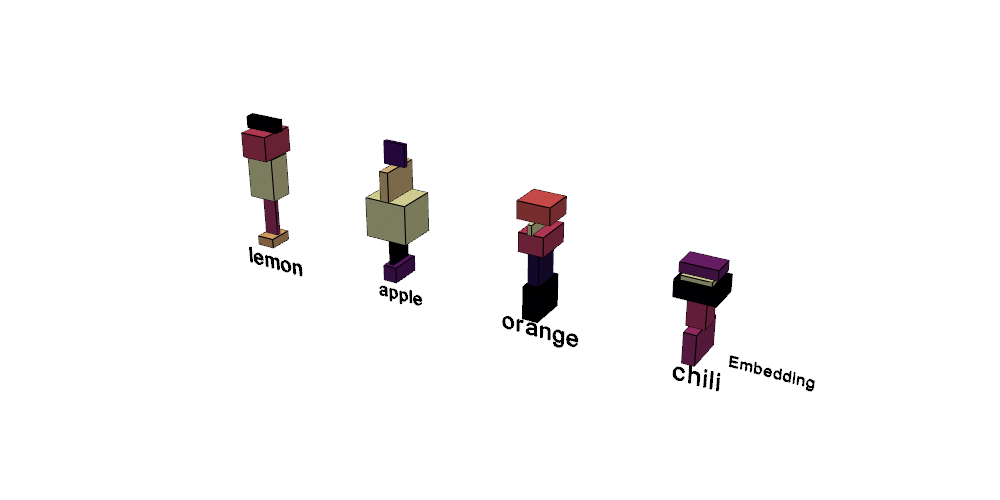

In [ ]:
# Test sequences for embedding visualization
texts = [
    "lemon apple orange chili",  # Food items with different taste profiles
]

for text in texts:
    print(f"Visualizing embeddings for: '{text}'")

    # Tokenize input text
    input_token_texts = [itos[i] for i in encode(text)]
    tokens = encode(text)

    # Get embeddings from the model's embedding table
    embeddings = (
        model.token_embedding_table(torch.tensor(tokens, device=device))
        .detach()
        .cpu()
        .numpy()
    )

    # Create snapshot with embeddings only (no transformer layers)
    vis = GPTLanguageModelSnapshot()
    vis.embeddings = embeddings

    # Render 3D visualization
    view_transformer_and_attention(
        snapshot=vis,
        input_token_texts=input_token_texts,
    )

**Visualizing Complete Forward Pass**

**Purpose**: Observe how information flows through the transformer:
1. **Initial embeddings**: Token + position representations
2. **Transformer layers**: How representations evolve
3. **Attention patterns**: Which tokens the model focuses on

This visualization reveals:
- How embeddings change through layers
- Attention weights between tokens
- Information flow in the network

Input text: 'i like spicy so i like'
Decoded: i like spicy so i like

Generating next token...
Input: i like spicy so i like
Output: orange
  orange               64.83%
  chili                33.29%
  apple                0.83%
  juicy                0.41%
  tastes               0.09%

Rendering 3D visualization...


/tmp/ipython-input-3606496810.py:127: PyVistaDeprecationWarning: 
../tmp/ipython-input-3606496810.py:127: Argument 'radius' must be passed as a keyword argument to function 'PolyDataFilters.tube'.
From version 0.50, passing this as a positional argument will result in a TypeError.
  ).tube(line_width * 0.01),
/usr/local/lib/python3.12/dist-packages/pyvista/plotting/plotter.py:1632: PyVistaDeprecationWarning: 
../usr/local/lib/python3.12/dist-packages/pyvista/plotting/plotter.py:1632: Argument 'render' must be passed as a keyword argument to function 'Renderer.reset_camera'.
From version 0.50, passing this as a positional argument will result in a TypeError.
  self.renderer.reset_camera(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


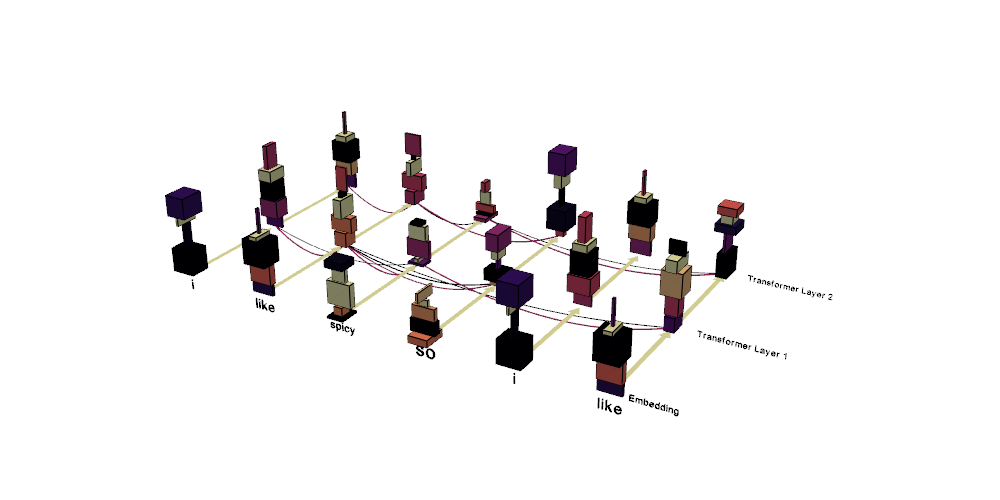

In [ ]:
# Text for forward pass visualization
text = "i like spicy so i like"

print(f"Input text: '{text}'")
print(f"Decoded: {decode(encode(text))}")

# Generate next token and display probabilities
print("\nGenerating next token...")
generate(text, max_new_tokens=1)

# Run forward pass to populate model snapshots
context_indices = torch.tensor([encode(text)], device=device)
_ = model(context_indices)  # Snapshots are captured during forward pass

# Get token texts for labeling
input_token_texts = [itos[i] for i in encode(text)]

# Visualize complete transformer forward pass
print("\nRendering 3D visualization...")
view_transformer_and_attention(
    snapshot=model.snapshots,
    input_token_texts=input_token_texts,
)